# Using Tractor catalog for positions

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
from astropy.nddata import bitmask

from scipy.ndimage import distance_transform_edt

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd

## Image query

In [2]:
def query_tractor(ra_b, dec_b, dist):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    #Bounds of the square we are querying objects for
    ra_min=ra_b
    ra_max = ra_b + dist
    dec_min=dec_b
    dec_max = dec_b + dist

    query = f"""
    SELECT ra, dec, mag_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g <= 21 AND mag_g >= 16
    """
    
    print("Querying the Astro Data Lab...")
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

tractor_df = query_tractor(0, 0, 1.0)

Querying the Astro Data Lab...


In [3]:
#for ra_b in [0,1]:
    #for dec_b in [-90,-89]:
       # info=query_tractor(ra_b,dec_b,dist=1)
       # print(info)

In [4]:
ra = tractor_df['ra']
dec = tractor_df['dec']

## Get bitmask info

Positions and masking radius for stars with magnitudes <16 are listed in the `mask_data_[N].npz` files. Each index is a different range of DEC:

| index | (DEC1, DEC2) |
| ----- | ----------- | 
| 0 | (-90, -66) |
| 1 | (-66, -42) |
| 2 | (-42, -18) |
| 3 | (-18, 6) |
| 4 | (6, 30) |

In [33]:
# there will be a text file to read from at some point lol
with np.load("mask_data_0.npz", mmap_mode='r') as mask_data:
    # print(mask_data['arr_0'][.dtype.byteorder)
    mask_array = mask_data['arr_0']
    mask_array_byteswap = mask_array.byteswap().newbyteorder()
    masked_stars = pd.DataFrame(mask_array_byteswap)

# masked stars has ra, dec, and radius (all degrees)
masked_stars

,ra,dec,radius
0,79.538911,-60.089958,0.014482
1,79.196783,-60.072246,0.011223
2,79.327845,-60.113370,0.010834
3,79.399679,-60.045816,0.007799
4,79.386393,-60.045617,0.006645
...,...,...,...
884367,56.176538,-89.893989,0.002565
884368,108.793613,-89.909216,0.002544
884369,67.834896,-89.920123,0.002519
884370,31.338298,-89.881080,0.002494


In [ ]:
# you can "query" the dataframe as you need
masked_stars.query(' (ra > 0.0) & (ra < 1.0) & (dec > -90.0) & (dec < -89.0)')

,ra,dec,radius
883759,0.398024,-89.286616,0.003989
883766,0.492577,-89.325364,0.003762
883767,0.189580,-89.243891,0.003582
883774,0.548044,-89.205598,0.003119
883775,0.409450,-89.196494,0.003093
883923,0.337313,-89.481089,0.010508
884236,0.344145,-89.657696,0.002204


In [17]:
pix_scale = 0.262 / 3600 # degrees
print(f"{pix_scale:.7f}")
# np.ceil(pix_scale * 4)

0.0000728


In [22]:
# find stars with radii outside integer bounds

# sort by radius
radius_sorted = masked_stars.sort_values(by='radius', ascending=False)

# apply a buffer of a minimum exclusion zone radius to all masks (arcsec)
exclusion_minimum = 20
radius_sorted['radius'] = radius_sorted['radius'] + (20 / 3600)

# convert to pixel radius
dim = 3600 * 4
radius_sorted['rad_pix'] = np.ceil(radius_sorted['radius']*dim).astype(int)
radius_sorted

radius_sorted['max_ra'] = radius_sorted['ra'] + radius_sorted['radius']
radius_sorted['min_ra'] = radius_sorted['ra'] - radius_sorted['radius']
radius_sorted['max_dec'] = radius_sorted['dec'] + radius_sorted['radius']
radius_sorted['min_dec'] = radius_sorted['dec'] - radius_sorted['radius']

expression = '(max_ra > ceil(ra)) | (min_ra < floor(ra)) | (max_dec > ceil(dec)) | (min_dec < floor(dec))'

radius_overlap = radius_sorted.query(expression)
# if max ra > ceil(ra) or min ra < floor(ra)
# or max dec > ceil(dec) or 

radius_overlap


,ra,dec,radius,rad_pix,max_ra,min_ra,max_dec,min_dec
389178,252.166115,-69.027640,0.280640,4042,252.446755,251.885475,-68.747000,-69.308280
1463459,211.331114,-76.796907,0.226048,3256,211.557162,211.105065,-76.570859,-77.022955
1113901,56.810584,-74.238453,0.203908,2937,57.014492,56.606676,-74.034544,-74.442361
1793944,335.008503,-80.439939,0.191322,2756,335.199825,334.817182,-80.248617,-80.631261
1666585,245.086454,-78.695914,0.176783,2546,245.263237,244.909670,-78.519130,-78.872697
...,...,...,...,...,...,...,...,...
1622914,235.006572,-78.278011,0.007732,112,235.014304,234.998840,-78.270279,-78.285743
1807232,88.996616,-80.811802,0.007732,112,89.004348,88.988884,-80.804070,-80.819534
1822755,155.124531,-80.997457,0.007732,112,155.132263,155.116799,-80.989725,-81.005189
1659070,211.993644,-78.688003,0.007732,112,212.001376,211.985912,-78.680271,-78.695735


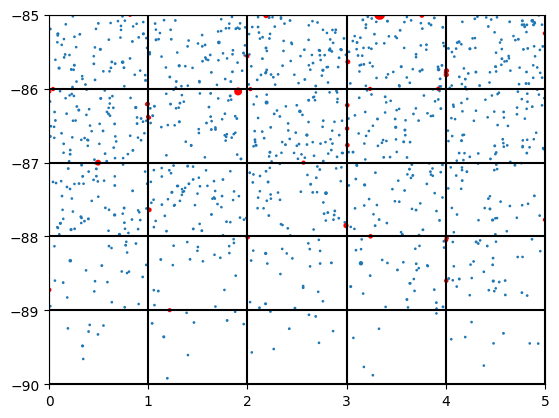

In [41]:
fig, ax = plt.subplots()
cube = radius_sorted.query('(ra > 0.0) & (ra < 5.0) & (dec > -90.0) & (dec < -66.0)')
overlap_cube = radius_overlap.query('(ra > 0.0) & (ra < 5.0) & (dec > -90.0) & (dec < -66.0)')
ax.vlines(np.arange(0,360), ymin=-90, ymax=-66, color='k')
ax.hlines(np.arange(-90,30), xmin=0, xmax=360, color='k')
ax.scatter(cube['ra'], cube['dec'], cube['radius']*100)
ax.scatter(overlap_cube['ra'], overlap_cube['dec'], overlap_cube['radius']*500, c='r')
ax.set(xlim=(0, 5), ylim=(-90, -85))
plt.show()

## Segmentation map

Start with OG seg map, without bitmask stuff yet

In [6]:
# creating seg map by pixels

dim = 3600*4
array = np.zeros((dim, dim), dtype=int)
# print(np.round(ra*dim).astype(int) - 1) 
ra_pix = np.round(ra*dim).astype(int) - 1
dec_pix = np.round(dec*dim).astype(int) - 1
# ra_pix

In [7]:
print(np.min(dec_pix))

-1


In [12]:
# masking for low magnitude objects

def mask_radius(mag_g, fov_radius=20):

    return (fov_radius/3600) + 1630./3600. * 1.396**(-mag_g)

rad = mask_radius(tractor_df['mag_g'])
array = np.zeros((dim, dim), dtype=int)

# print(rad*dim)
rad_pix = np.ceil(rad*dim).astype(int)
# print(rad_pix)

# array[1000:2000, 1000:2000] = 1
ra_pix_test = [100, 2000, 5000]
dec_pix_test = [100, 2000, 4000]
r_test = [100, 200, 50]

print(np.max(rad_pix))
print(np.array(ra_pix))

# array[1036:1236 , 88:288] = 1
# array[100:200][88:288] = 1
# array[100:431, 100:200] = 1
print(array.shape)
# array[1036:1236][100:200] = 1

for x, y in zip(ra_pix,dec_pix):
    r = 100
    # print(f"{x}, {y}, {r}")
    ra_max = x + r if x+r <= dim else dim
    ra_min = x - r if x-r >= 0 else 0
    dec_max = y + r if y+r <= dim else dim
    dec_min = y - r if y-r >= 0 else 0
    
    # print(f"ra min: {ra_min}, ra max: {ra_max}")
    # print(f"dec min: {dec_min}, dec max: {dec_max}")
    
    array[ra_min:ra_max, dec_min:dec_max] = 1
    # print(array[ra_min:ra_max][0].shape)

112
[ 1136  1134  2956 ... 13903 14178 14336]
(14400, 14400)


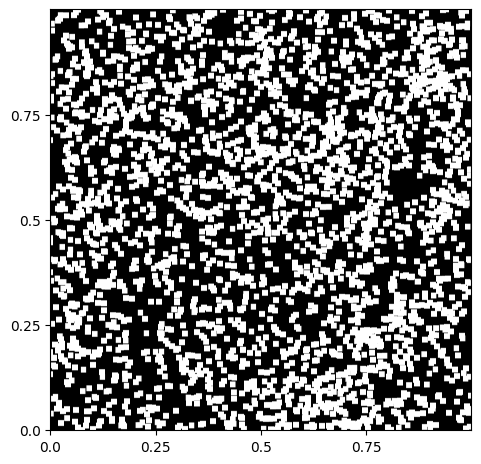

In [13]:
# distance = distance_transform_edt(array == 0)

# excl_map = np.copy(array)

# excl_map[distance <= 20] = 1

positions = np.linspace(0,dim,5)
labels = np.linspace(0,1,5)

fig, ax = plt.subplots()
ax.set_xticks(positions, labels)
ax.set_yticks(positions, labels)

plt.tight_layout()
plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)


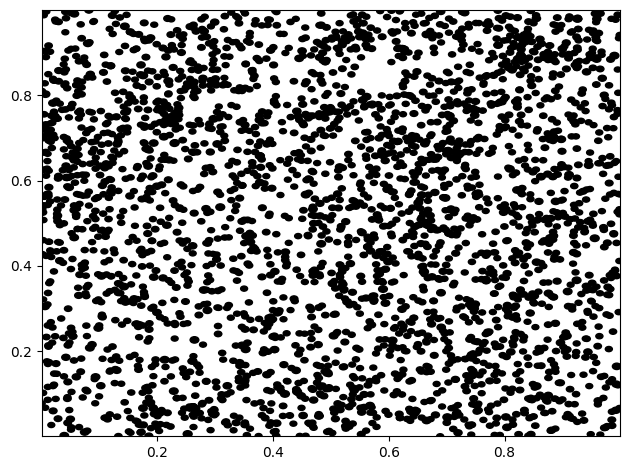

In [7]:
def plot_exclusion_zones():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(min(ra),max(ra))
    ax.set_ylim(min(dec), max(dec))

    for x, y, r in zip(tractor_df['ra'], tractor_df['dec'], rad):
        c = plt.Circle((x,y), r, color='black')
        ax.add_patch(c)

    plt.tight_layout()
    plt.show()

    return

excl_map = plot_exclusion_zones()


In [8]:
def define_grid(fov=60):
    
    gridlines = np.arange(min(ra), max(ra), (fov/3600))
    return gridlines

gridlines = define_grid()

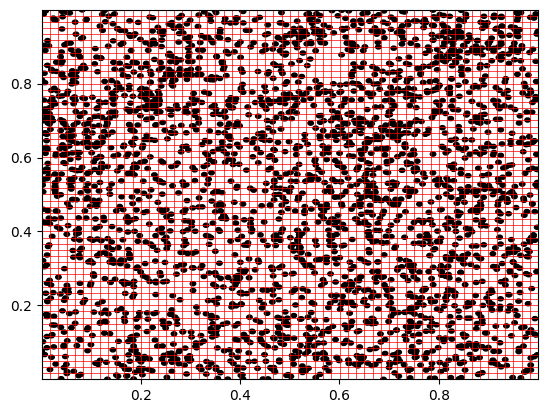

In [9]:
def create_grid():

    # Creating exclusion map with grid
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim((min(ra),max(ra)))
    ax.set_ylim((min(dec),max(dec)))

    for x, y, r in zip(ra, dec, rad):
        c = plt.Circle((x,y), 0.005556, color='black', fill='false')
        ax.add_patch(c)

    plt.vlines(gridlines, min(dec), max(dec), color='red', linewidth=0.5)
    plt.hlines(gridlines, min(ra), max(ra), color= 'red', linewidth=0.5)
    plt.margins(0)
    plt.show()

    return

create_grid()

In [ ]:
def find_dark_regions():

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = gridlines[i], gridlines[i + 1]
            y_start, y_end = gridlines[j], gridlines[j + 1]
            
            if np.all(excl_map[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans

dr_trans = find_dark_regions()

TypeError: 'NoneType' object is not subscriptable